# Gaussian Process Regression

In [23]:
from IPython.display import clear_output

import sys

import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import numpy as np

import GPJax_AScannell as gpjaxas

import optax
from flax import nnx
from gpjax.parameters import DEFAULT_BIJECTION, Parameter, PositiveReal, Real, transform

# from jax.experimental import optimizers
# from gpjax.datasets import CustomDataset, NumpyLoader
# from gpjax.kernels import SquaredExponential
# from gpjax.parameters import build_constrain_params
# from gpjax.mean_functions import Zero
# from gpjax.likelihoods import Gaussian
# from gpjax.models import SVGP
# from torch.utils.data import DataLoader
from jaxtyping import Float, install_import_hook
from gpjax.parameters import Static
from gpjax.typing import Array

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax

from project_name import dynamics_models

import copy

key = jrandom.key(10)

In [24]:
N = 100  # number of points
D = 1  # number of input dimensions
M = 15  # number of inducing points
L = 2  # number of latent GPs
P = 5  # number of observations = output dimensions
# TODO the above is not linked to the function at all

def generate_data(N=100):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs = N x D
    G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X))  # G = N x L
    if P == 2:
        W = np.array([[0.5, -0.3], [-0.4, 0.43]])  # L x P
    if P == 3:
        W = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])  # L x P
    else:
        W = np.array([[0.5, -0.3, 1.5, 2.1, -0.4], [-0.4, 0.43, 0.0, 0.53, 0.1]])  # L x P
    F = np.matmul(G, W)  # N x P
    Y = F + np.random.randn(*F.shape) * ([0.2] * P)

    return X, Y

X, Y = data = generate_data(N)

lower=-8.0
upper=8.0
Xtest = np.linspace(lower, upper, 100)[:, None]

In [25]:
def plot_model(m, params):
    pY, pYv = m.predict_y(params, Xtest, train_data, full_cov=False)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(X, Y, "x")
    plt.gca().set_prop_cycle(None)
    plt.plot(Xtest, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(Xtest[:, 0], top, bot, alpha=0.3)
    plt.xlabel("X")
    plt.ylabel("f")
    # plt.title(f"ELBO: {m.elbo(data):.3}")
    # plt.plot(Z, Z * 0.0, "o")

In [26]:
train_data = gpjax.Dataset(X=X, y=Y)
# kernel = gpjaxas.kernels.SeparateIndependent([gpjaxas.kernels.SquaredExponential() + gpjaxas.kernels.Linear() for idx in range(P)])
kernel = gpjaxas.kernels.SeparateIndependent([gpjaxas.kernels.SquaredExponential() for idx in range(P)])
likelihood = gpjaxas.likelihoods.Gaussian()
mean_function = gpjaxas.mean_functions.Zero(output_dim=P)
gp = gpjaxas.models.GPR(kernel, likelihood, mean_function, num_latent_gps=P)

In [27]:
gp_params = gp.get_params()
print(gp_params)

{'kernel': [{'lengthscales': Array([1.], dtype=float64), 'variance': Array(1., dtype=float64, weak_type=True)}, {'lengthscales': Array([1.], dtype=float64), 'variance': Array(1., dtype=float64, weak_type=True)}, {'lengthscales': Array([1.], dtype=float64), 'variance': Array(1., dtype=float64, weak_type=True)}, {'lengthscales': Array([1.], dtype=float64), 'variance': Array(1., dtype=float64, weak_type=True)}, {'lengthscales': Array([1.], dtype=float64), 'variance': Array(1., dtype=float64, weak_type=True)}], 'likelihood': {'variance': Array([1.], dtype=float64)}, 'mean_function': None}


In [28]:
gp_transforms = gp.get_transforms()
constrain_params = gpjaxas.parameters.build_constrain_params(gp_transforms)

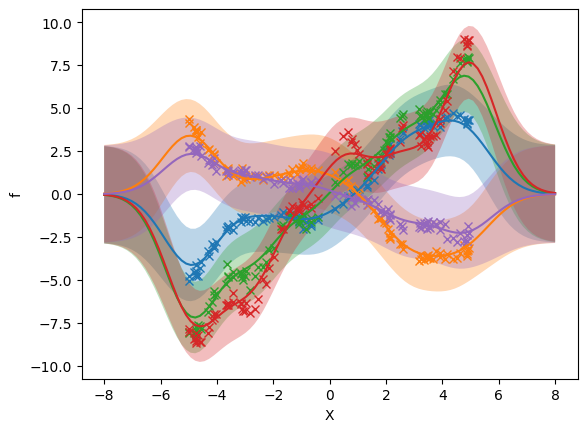

In [29]:
plot_model(gp, gp_params)

In [30]:
print(gp_params)

{'kernel': [{'lengthscales': Array([1.], dtype=float64), 'variance': Array(1., dtype=float64, weak_type=True)}, {'lengthscales': Array([1.], dtype=float64), 'variance': Array(1., dtype=float64, weak_type=True)}, {'lengthscales': Array([1.], dtype=float64), 'variance': Array(1., dtype=float64, weak_type=True)}, {'lengthscales': Array([1.], dtype=float64), 'variance': Array(1., dtype=float64, weak_type=True)}, {'lengthscales': Array([1.], dtype=float64), 'variance': Array(1., dtype=float64, weak_type=True)}], 'likelihood': {'variance': Array([1.], dtype=float64)}, 'mean_function': None}


In [31]:
# learning_rate = 1e-3
learning_rate = 1e-2

# Create optimizer
tx = optax.adam(learning_rate)
# gp_params = constrain_params(gp_params)
opt_state = tx.init(gp_params)

In [32]:
objective = lambda p, d: -gp.log_marginal_likelihood(p, d)

In [33]:
def create_sep_params(params):
    kernels = params["kernel"]
    lengthscales = jnp.stack([k['lengthscales'] for k in kernels])
    variances = jnp.expand_dims(jnp.stack([k['variance'] for k in kernels]), axis=-1)
    likelihood_variances = jnp.tile(params["likelihood"]["variance"], (P, 1))

    params["kernel"] = {"lengthscales": lengthscales, "variance": variances}
    params["likelihood"] = {"variance": likelihood_variances}

    return params

sep_params = create_sep_params(copy.deepcopy(gp_params))

def create_sep_transform(params):
    params["kernel"] = {"lengthscales": params["kernel"][0]["lengthscales"],
                        "variance": params["kernel"][0]["variance"]}
    return params

sep_transforms = create_sep_transform(gp.get_transforms())
sep_constrain_params = gpjaxas.parameters.build_constrain_params(sep_transforms)

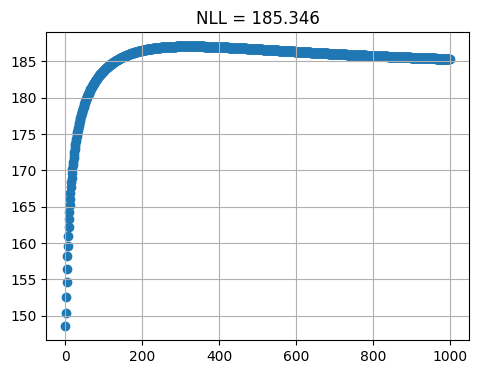

{'kernel': [{'lengthscales': Array([1.], dtype=float64), 'variance': Array(1., dtype=float64, weak_type=True)}, {'lengthscales': Array([1.], dtype=float64), 'variance': Array(1., dtype=float64, weak_type=True)}, {'lengthscales': Array([1.], dtype=float64), 'variance': Array(1., dtype=float64, weak_type=True)}, {'lengthscales': Array([1.], dtype=float64), 'variance': Array(1., dtype=float64, weak_type=True)}, {'lengthscales': Array([1.], dtype=float64), 'variance': Array(1., dtype=float64, weak_type=True)}], 'likelihood': {'variance': Array([1.], dtype=float64)}, 'mean_function': None}
{'kernel': [{'lengthscales': Array([5.9811002], dtype=float64), 'variance': Array([8.83475711], dtype=float64)}, {'lengthscales': Array([6.15240412], dtype=float64), 'variance': Array([8.32234642], dtype=float64)}, {'lengthscales': Array([5.44308915], dtype=float64), 'variance': Array([9.31420063], dtype=float64)}, {'lengthscales': Array([5.08850173], dtype=float64), 'variance': Array([9.24020725], dtype=

In [34]:
num_iters = 600  # 1000

objective = lambda p, d: -gp.multi_output_log_marginal_likelihood(p, d)
tx = optax.adam(learning_rate)

def optimise_single_gp(data_x, data_y, init_params):
    # Create optimiser state
    opt_state = tx.init(init_params)
    train_data = gpjax.Dataset(data_x, jnp.expand_dims(data_y, axis=-1))

    # Optimisation step.
    def _step_fn(carry, unused):
        params, opt_state = carry
        params = sep_constrain_params(copy.deepcopy(params))

        loss_val, loss_gradient = jax.value_and_grad(objective)(params, train_data)
        updates, opt_state = tx.update(loss_gradient, opt_state, params)
        params = optax.apply_updates(params, updates)

        carry = params, opt_state
        return carry, loss_val

    # Optimisation loop.
    (end_params, _), history = jax.lax.scan(jax.jit(_step_fn), (init_params, opt_state), None, 1000)

    return end_params, history

new_params, loss_history = jax.vmap(optimise_single_gp, in_axes=(None, 1, 0))(train_data.X, train_data.y, sep_params)
new_kernel = gpjaxas.kernels.SeparateIndependent([gpjaxas.kernels.SquaredExponential(lengthscales=new_params["kernel"]["lengthscales"][new_idx], variance=new_params["kernel"]["variance"][new_idx]) for new_idx in range(P)])
new_kernel_params = new_kernel.get_params()

optimised_params = copy.deepcopy(gp_params)
optimised_params["kernel"] = new_kernel_params

loss_history = jnp.mean(loss_history, axis=0)

plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.title("NLL = %.3f" % jnp.mean(jnp.array(loss_history[-32:])))
plt.scatter(jnp.arange(len(loss_history)), jnp.array(loss_history))
plt.grid()
plt.show()
print(gp_params)
print(optimised_params)

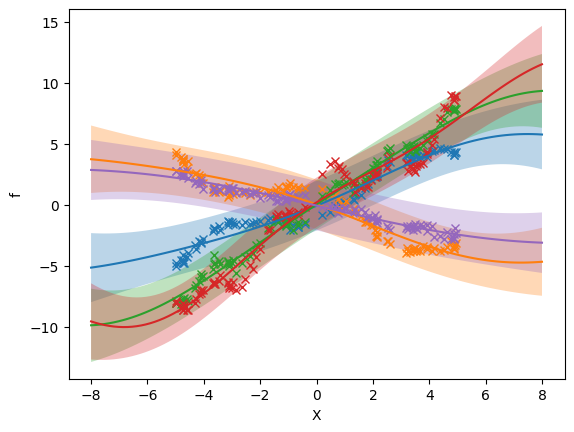

In [35]:
plot_model(gp, optimised_params)

In [36]:
class MultiOutputSeparateIndependent(gpjax.kernels.AbstractKernel):
    def __init__(self, num_outputs: int, kernels: list[gpjax.kernels.AbstractKernel] = None):
        if kernels is None:
            kernels = [gpjax.kernels.RBF(active_dims=list(np.linspace(0, num_outputs-1, num_outputs))) for _ in range(num_outputs)]

        # Ensure the number of kernels matches the number of outputs
        assert len(kernels) == num_outputs, "Number of kernels must match number of outputs"

        self.kernels = kernels
        self.num_outputs = num_outputs

        # Initialize parent class with dense kernel computation
        super().__init__(compute_engine=gpjax.kernels.computations.DenseKernelComputation())

    def __call__(self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]) -> Float[Array, "1"]:
        # Extract the output dimension index (assumed to be the last dimension)
        z = jnp.array(X[-1], dtype=int)
        zp = jnp.array(Xp[-1], dtype=int)

        # Create a switch matrix to select the appropriate kernel
        switches = jnp.zeros(self.num_outputs)
        switches = switches.at[z].set(1)
        switches = switches.at[zp].set(switches[zp])

        # Compute kernel value using the selected kernel
        kernel_value = 0.0
        for i in range(self.num_outputs):
            kernel_value += switches[i] * self.kernels[i](X[:-1], Xp[:-1])

        return kernel_value

In [37]:
def adjust_dataset(dataset):
    num_points = dataset.X.shape[0]
    in_dim = dataset.X.shape[1]
    out_dim = dataset.y.shape[1]
    # print(f"Num Points: {num_points}; Num Inputs: {in_dim}; Num Outputs: {out_dim}")

    label = jnp.tile(jnp.array(jnp.linspace(0, out_dim-1, out_dim)), num_points)

    new_x = jnp.hstack((jnp.repeat(dataset.X, repeats=out_dim, axis=0), jnp.expand_dims(label, axis=-1)))

    new_y = dataset.y.reshape(-1, 1)

    assert new_x.shape == (num_points * out_dim, in_dim + 1), "Output X is the wrong shape"
    assert new_y.shape == (num_points * out_dim, 1), "Output Y is the wrong shape"

    return gpjax.Dataset(new_x, new_y)

# print(train_data.X.shape, train_data.y.shape)
gpjax_train_data = adjust_dataset(train_data)
# print(gpjax_train_data.X.shape, gpjax_train_data.y.shape)
x_test_data = adjust_dataset(gpjax.Dataset(Xtest, jnp.ones((Xtest.shape[0], P))))
gpjax_Xtest = x_test_data.X

In [38]:
def plot_model_gpjax(posterior):
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, "kx", mew=2, alpha=0.5)
    # plt.plot(params["inducing_variable"], jnp.zeros([num_inducing, input_dim]), "|", mew=2, alpha=0.5)
    latent_dist = posterior.predict(gpjax_Xtest, gpjax_train_data)
    predictive_dist = posterior.likelihood(latent_dist)  # this predicts y and not f
    mean = predictive_dist.mean()
    std = predictive_dist.stddev()
    mean = mean.reshape(-1, P)
    std = std.reshape(-1, P)
    plt.plot(Xtest, mean, "magenta", lw=2)
    for i in range(mean.shape[1]):
        top = mean[:, i] + 2.0 * std[:, i] ** 0.5
        bot = mean[:, i] - 2.0 * std[:, i] ** 0.5
        plt.fill_between(Xtest[:, 0], top, bot, alpha=0.3)
    plt.xlabel("X")
    plt.ylabel("f")
    plt.show()

In [39]:
active_dims = jnp.arange(0, P, P)

class SeparateIndependent2(gpjax.kernels.AbstractKernel):
    def __init__(self,
                 kernel0: gpjax.kernels.AbstractKernel = gpjax.kernels.RBF(active_dims=[0, 1]) + gpjax.kernels.Linear(active_dims=[0, 1]),
                 kernel1: gpjax.kernels.AbstractKernel = gpjax.kernels.RBF(active_dims=[0, 1]) + gpjax.kernels.Linear(active_dims=[0, 1]),
                 ):
        self.kernel0 = kernel0
        self.kernel1 = kernel1
        super().__init__(compute_engine=gpjax.kernels.computations.DenseKernelComputation())

    def __call__(self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]) -> Float[Array, "1"]:
        # standard RBF-SE kernel is x and x' are on the same output, otherwise returns 0
        z = jnp.array(X[-1], dtype=int)
        zp = jnp.array(Xp[-1], dtype=int)

        # achieve the correct value via 'switches' that are either 1 or 0
        k0_switch = ((z + 1) % 2) * ((zp + 1) % 2)
        k1_switch = z * zp

        return k0_switch * self.kernel0(X, Xp) + k1_switch * self.kernel1(X, Xp)

In [40]:
class SeparateIndependent3(gpjax.kernels.AbstractKernel):
    def __init__(self,
                 kernel0: gpjax.kernels.AbstractKernel = gpjax.kernels.RBF(active_dims=[0, 1, 2]) + gpjax.kernels.Linear(active_dims=[0, 1, 2]),
                 kernel1: gpjax.kernels.AbstractKernel = gpjax.kernels.RBF(active_dims=[0, 1, 2]) + gpjax.kernels.Linear(active_dims=[0, 1, 2]),
                 kernel2: gpjax.kernels.AbstractKernel = gpjax.kernels.RBF(active_dims=[0, 1, 2]) + gpjax.kernels.Linear(active_dims=[0, 1, 2]),
                 ):
        self.kernel0 = kernel0
        self.kernel1 = kernel1
        self.kernel2 = kernel2
        super().__init__(compute_engine=gpjax.kernels.computations.DenseKernelComputation())

    def __call__(self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]) -> Float[Array, "1"]:
        # standard RBF-SE kernel is x and x' are on the same output, otherwise returns 0

        z = jnp.array(X[-1], dtype=int)
        zp = jnp.array(Xp[-1], dtype=int)

        # achieve the correct value via 'switches' that are either 1 or 0
        k0_switch = ((z + 1) % 3 == 0) * ((zp + 1) % 3 == 0)
        k1_switch = (z % 3 == 1) * (zp % 3 == 1)
        k2_switch = (z % 3 == 2) * (zp % 3 == 2)

        return k0_switch * self.kernel0(X, Xp) + k1_switch * self.kernel1(X, Xp) + k2_switch * self.kernel2(X, Xp)

(100, 1) (100, 5)
(500, 2) (500, 1)


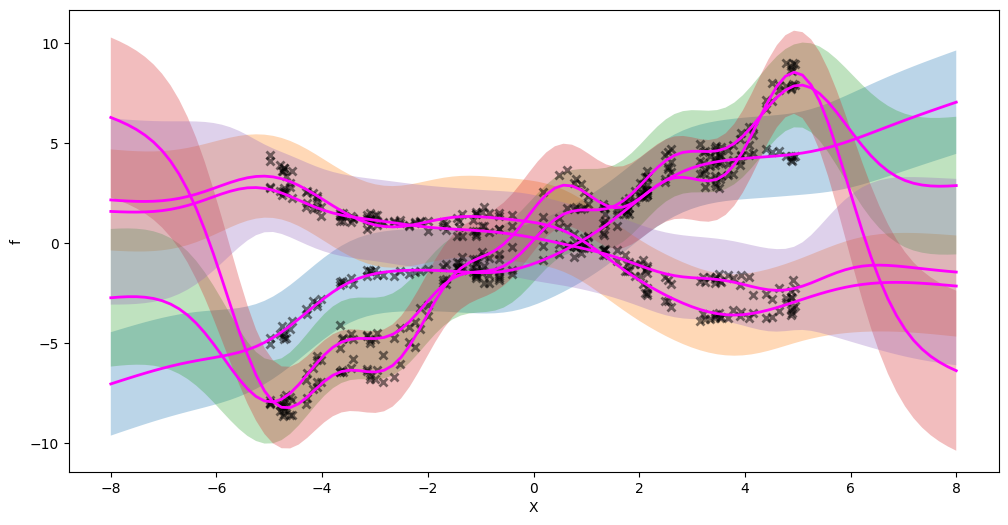

In [41]:
print(train_data.X.shape, train_data.y.shape)
print(gpjax_train_data.X.shape, gpjax_train_data.y.shape)

mean = gpjax.mean_functions.Zero()
# kernel = MultiOutputSeparateIndependent(P)
kernel = SeparateIndependent2()
prior = gpjax.gps.Prior(mean_function=mean, kernel=kernel)
likelihood = gpjax.likelihoods.Gaussian(num_datapoints=gpjax_train_data.n, obs_stddev=jnp.sqrt(1.0))
posterior = prior * likelihood

# _, gpjax_prior_params = nnx.split(prior, Parameter)
# _, gpjax_likelihood_params = nnx.split(likelihood, Parameter)
# print(gpjax_prior_params)

plot_model_gpjax(posterior)

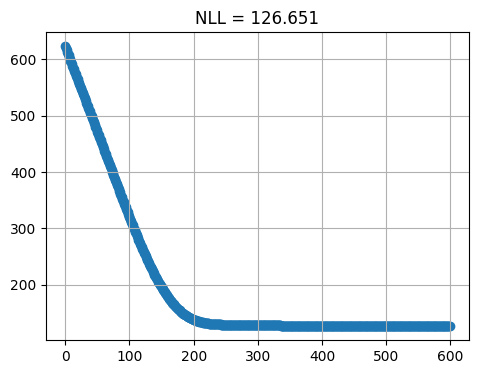

In [42]:
key, _key = jrandom.split(key)
opt_posterior, loss_history = gpjax.fit(model=posterior,
                                     objective=lambda p, d: -gpjax.objectives.conjugate_mll(p, d),
                                     train_data=gpjax_train_data,
                                     optim=optax.adam(learning_rate=learning_rate),
                                     num_iters=num_iters,
                                     safe=True,
                                     key=_key,
                                     verbose=False)
plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.title("NLL = %.3f" % jnp.mean(jnp.array(loss_history[-32:])))
plt.scatter(jnp.arange(len(loss_history)), jnp.array(loss_history))
plt.grid()
plt.show()

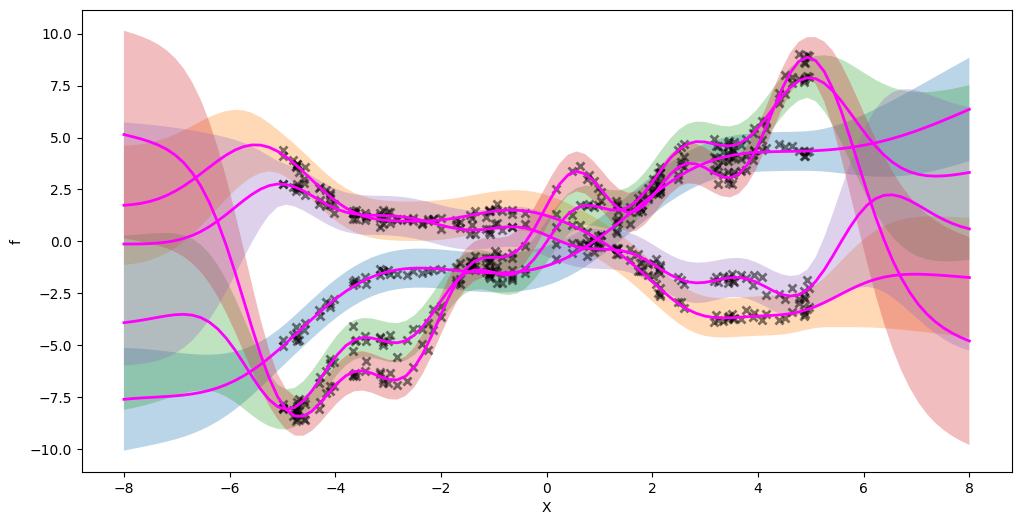

In [43]:
# _, gpjax_prior_params = nnx.split(opt_posterior.prior, Parameter)
# _, gpjax_likelihood_params = nnx.split(opt_posterior.likelihood, Parameter)
# print(gpjax_prior_params)

plot_model_gpjax(opt_posterior)